<center style><h1>Computer Assignment 5 Phase 1</h1></center>
<center style><h1>Neural Networks</h1></center>

**In this assignment we are given some pictures in 10 different classes. We are about to classify these pictures
using Feed Forward in Neural Networks.**

## Review Data and PreProcess

* Each pixel is having a value in range of 0 to 255
* If we no scale our values we might face values with different measure scales and this can cause harm calculation

In [38]:
import cv2
import random
import pandas
from sklearn.model_selection import train_test_split

label = pandas.read_csv('cifar_dataset/labels.csv')
train, test = train_test_split(label, test_size=0.2)

choice = random.randint(0, len(train))
img = cv2.imread(f'cifar_dataset/data/{train.iloc[choice].id}.png')
print(img)
print(f'Max = {img.max()}')
print(f'Min = {img.min()}')

[[[123 139 139]
  [147 161 162]
  [183 198 201]
  ...
  [165 184 189]
  [159 178 183]
  [155 174 179]]

 [[ 17  21  22]
  [ 34  38  38]
  [110 121 122]
  ...
  [167 187 192]
  [164 183 188]
  [160 178 184]]

 [[ 11  14  14]
  [ 12  16  14]
  [  7  13  11]
  ...
  [167 186 191]
  [165 184 189]
  [161 179 185]]

 ...

 [[149 145 145]
  [149 147 147]
  [138 137 137]
  ...
  [137 138 136]
  [133 133 131]
  [129 129 127]]

 [[157 153 152]
  [158 155 155]
  [153 151 151]
  ...
  [136 135 134]
  [135 133 132]
  [127 125 124]]

 [[161 158 155]
  [166 161 162]
  [150 146 147]
  ...
  [135 133 132]
  [129 127 126]
  [126 124 123]]]
Max = 227
Min = 2


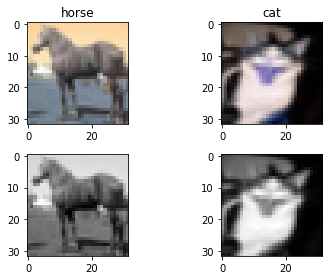

In [39]:
import numpy
from matplotlib import pyplot as plot

pictures = []
categories = ['cat', 'horse']

while len(categories) != 0:
    rand_pic = random.randint(0, len(train))
    l = str(train.iloc[rand_pic].label)
    if l in categories:
        pictures.append(rand_pic)
        categories.remove(train.iloc[rand_pic].label)


def rgb2gray(rgb):
    return numpy.dot(rgb[..., :3], [0.2989, 0.5870, 0.1140])


plot.figure()

for i in range(2):
    plot.subplot(2, 2, i + 1)
    image = cv2.imread(f'cifar_dataset/data/{train.iloc[pictures[i]].id}.png')
    plot.imshow(image)
    plot.title(train.iloc[pictures[i]].label)
    plot.subplot(2, 2, i + 3)
    plot.imshow(rgb2gray(image), cmap='gray')

plot.tight_layout()
plot.show()

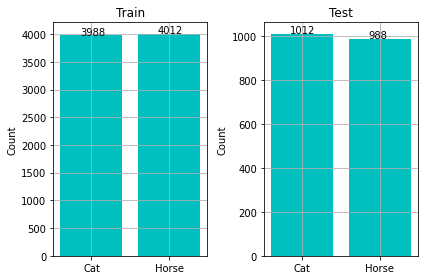

In [40]:
plot.figure()

plot.subplot(1, 2, 1)
bars = plot.bar(['Cat', 'Horse'], [train['label'].value_counts()['cat'], train['label'].value_counts()['horse']], color='c')
plot.ylabel('Count')
plot.title('Train')
plot.grid()
for bar in bars:
    y_val = bar.get_height()
    plot.text(bar.get_x() + 0.25, y_val + 1, y_val)

plot.subplot(1, 2, 2)
bars = plot.bar(['Cat', 'Horse'], [test['label'].value_counts()['cat'], test['label'].value_counts()['horse']], color='c')
plot.ylabel('Count')
plot.title('Test')
plot.grid()
for bar in bars:
    y_val = bar.get_height()
    plot.text(bar.get_x() + 0.25, y_val + 1, y_val)

plot.tight_layout()
plot.show()

In [41]:
def normalize_data(data):
    return (data - numpy.min(data)) / (numpy.max(data) - numpy.min(data))


img = normalize_data(img)
print(img)
print(f'Max = {img.max()}')
print(f'Min = {img.min()}')

[[[0.53777778 0.60888889 0.60888889]
  [0.64444444 0.70666667 0.71111111]
  [0.80444444 0.87111111 0.88444444]
  ...
  [0.72444444 0.80888889 0.83111111]
  [0.69777778 0.78222222 0.80444444]
  [0.68       0.76444444 0.78666667]]

 [[0.06666667 0.08444444 0.08888889]
  [0.14222222 0.16       0.16      ]
  [0.48       0.52888889 0.53333333]
  ...
  [0.73333333 0.82222222 0.84444444]
  [0.72       0.80444444 0.82666667]
  [0.70222222 0.78222222 0.80888889]]

 [[0.04       0.05333333 0.05333333]
  [0.04444444 0.06222222 0.05333333]
  [0.02222222 0.04888889 0.04      ]
  ...
  [0.73333333 0.81777778 0.84      ]
  [0.72444444 0.80888889 0.83111111]
  [0.70666667 0.78666667 0.81333333]]

 ...

 [[0.65333333 0.63555556 0.63555556]
  [0.65333333 0.64444444 0.64444444]
  [0.60444444 0.6        0.6       ]
  ...
  [0.6        0.60444444 0.59555556]
  [0.58222222 0.58222222 0.57333333]
  [0.56444444 0.56444444 0.55555556]]

 [[0.68888889 0.67111111 0.66666667]
  [0.69333333 0.68       0.68      ]


# Dataloader

In [42]:
class Dataloader:

    def __init__(self, data, labels, n_classes, batch_size=None, shuffle=False):
        assert len(data) == len(labels)
        self.__n_classes = n_classes
        self.__batch_size = batch_size
        self.__shuffle = shuffle
        self.__data = data
        self.__onehot_labels = self.__onehot(labels, self.__n_classes)

    def __onehot(self, labels, n_classes):
        labels = labels.astype(int)
        onehot_vectors = numpy.zeros((labels.size, n_classes))
        onehot_vectors[numpy.arange(labels.size), labels] = 1.0
        return onehot_vectors

    def __shuffle_dataset(self):
        total_data = numpy.c_[
            self.__data.reshape(len(self.__data), -1), self.__onehot_labels.reshape(len(self.__onehot_labels), -1)]
        numpy.random.shuffle(total_data)
        data = total_data[:, :self.__data.size // len(self.__data)].reshape(self.__data.shape)
        self.__onehot_labels = total_data[:, self.__data.sizelen(self.__data):].reshape(self.__onehot_labels.shape)
        self.__data = data

    def __iter__(self):
        if self.__shuffle:
            self.__shuffle_dataset()

        if self.__batch_size == None:
            yield (numpy.matrix(self.__data), numpy.matrix(self.__onehot_labels))
            return

        for idx in range(0, len(self.__data), self.__batch_size):
            yield (numpy.matrix(self.__data[idx:idx + self.__batch_size]),
                   numpy.matrix(self.__onehot_labels[idx:idx + self.__batch_size]))

# Activation Functions

In [43]:
class Identical:

    def __init__(self): pass

    def __val(self, matrix):
        identical_value = numpy.matrix(matrix, dtype=float)
        return identical_value

    def derivative(self, matrix):
        temp = numpy.matrix(matrix, dtype=float)
        identical_derivative = numpy.matrix(numpy.full(numpy.shape(temp), 1.))
        return identical_derivative

    def __call__(self, matrix):
        return self.__val(matrix)


class Relu:

    def __init__(self): pass

    def __val(self, matrix):
        temp = numpy.matrix(matrix, dtype=float)
        relu_value = numpy.matrix(numpy.maximum(temp, 0.))
        return relu_value

    def derivative(self, matrix):
        relu_derivative = numpy.matrix(matrix, dtype=float)
        relu_derivative[relu_derivative <= 0] = 0.0
        relu_derivative[relu_derivative > 0] = 1.0
        return relu_derivative

    def __call__(self, matrix):
        return self.__val(matrix)


class LeakyRelu:

    def __init__(self, negative_slope=0.01):
        self.negative_slope = 0.01

    def __val(self, matrix):
        temp = numpy.matrix(matrix, dtype=float)
        leacky_relu_value = numpy.matrix(numpy.where(temp > 0, temp, temp * self.negative_slope))
        return leacky_relu_value

    def derivative(self, matrix):
        temp = numpy.matrix(matrix, dtype=float)
        leacky_relu_derivative = numpy.ones_like(temp)
        leacky_relu_derivative[temp <= 0] = self.negative_slope
        return leacky_relu_derivative

    def __call__(self, matrix):
        return self.__val(matrix)


class Sigmoid:
    def __init__(self): pass

    def __val(self, matrix):
        temp = numpy.matrix(matrix, dtype=float)
        sigmoid_value = numpy.matrix(1.0 / (1.0 + numpy.exp(-temp)))
        return sigmoid_value

    def derivative(self, matrix):
        sigmoid_derivative = numpy.multiply(self.__val(matrix), (1. - self.__val(matrix)))
        return sigmoid_derivative

    def __call__(self, matrix):
        return self.__val(matrix)


class Softmax:

    def __init__(self): pass

    def __val(self, matrix):
        temp = numpy.matrix(matrix, dtype=float)
        softmax_value = numpy.exp(temp - numpy.max(temp))
        softmax_value /= softmax_value.sum(axis=1)
        return softmax_value

    def __call__(self, matrix):
        return self.__val(matrix)


class Tanh:

    def __init__(self): pass

    def __val(self, matrix):
        temp = numpy.matrix(matrix, dtype=float)
        tanh_value = numpy.matrix((numpy.exp(temp) - numpy.exp(-temp)) / (numpy.exp(temp) + numpy.exp(-temp)))
        return tanh_value

    def derivative(self, matrix):
        tanh_derivative = 1 - numpy.power(self.__val(matrix), 2)
        return tanh_derivative

    def __call__(self, matrix):
        return self.__val(matrix)


# Loss Function

In [44]:
class CrossEntropy:

    def __init__(self): pass

    def __val(self, true_val, expected_val):
        assert numpy.shape(true_val) == numpy.shape(expected_val)
        softmax = Softmax()
        cross_entropy_value = numpy.sum(
            -numpy.multiply(numpy.matrix(expected_val, dtype=float), numpy.log(softmax(true_val))), axis=1)
        return cross_entropy_value

    def derivative(self, true_val, expected_val):
        assert numpy.shape(true_val) == numpy.shape(expected_val)
        softmax = Softmax()
        cross_entropy_derivative = softmax(true_val) - expected_val
        return cross_entropy_derivative

    def __call__(self, true_val, expected_val):
        return self.__val(true_val, expected_val)

# Layer

In [45]:
class Layer:

    DEFAULT_LOW, DEFAULT_HIGH, DEFAULT_MEAN, DEFAULT_VAR = 0, 0.05, 0., 1.

    def __init__(self, input_size, output_size, activation=Identical(), initial_weight='uniform',
                 **initializing_parameters):

        assert type(initial_weight) == str, 'Undefined activation function!'
        self.__weight_initializer_dict = {'uniform': self.__uniform_weight, 'normal': self.__normal_weight}
        assert initial_weight in self.__weight_initializer_dict, 'Undefined weight initialization function!'

        self.__n_neurons = output_size
        weight_initializer = self.__weight_initializer_dict[initial_weight]
        self.__weight = weight_initializer(input_size, self.__n_neurons, **initializing_parameters)
        self.__bias = weight_initializer(1, self.__n_neurons, **initializing_parameters)
        self.__activation = activation

        self.__last_input = None
        self.__last_activation_input = None
        self.__last_activation_output = None
        self.__last_activation_derivative = None

    def forward(self, layer_input):
        assert numpy.ndim(layer_input) == 2
        assert numpy.size(self.__weight, 0) == numpy.size(layer_input, 1)
        self.__last_input = layer_input
        self.__last_activation_input = numpy.add(numpy.dot(self.__last_input, self.__weight), self.__bias)
        self.__last_activation_output = self.__activation(self.__last_activation_input)
        self.__last_activation_derivative = self.__activation.derivative(self.__last_activation_output)
        return self.__last_activation_output

    def update_weights(self, backprop_tensor, lr):
        assert numpy.ndim(backprop_tensor) == 2
        assert numpy.size(backprop_tensor, 0) == numpy.size(self.__last_activation_derivative, 0)
        assert numpy.size(backprop_tensor, 1) == self.__n_neurons
        backprop_tensor = numpy.multiply(backprop_tensor, self.__last_activation_derivative)
        self.__weight -= (lr * numpy.dot(self.__last_input.T, backprop_tensor))
        self.__bias -= (lr * numpy.dot(numpy.ones((1, backprop_tensor.shape[0])), backprop_tensor))
        backprop_tensor = numpy.dot(backprop_tensor, self.__weight.T)
        return backprop_tensor

    def __uniform_weight(self, dim1, dim2, **initializing_parameters):
        low, high = self.DEFAULT_LOW, self.DEFAULT_HIGH
        if 'low' in initializing_parameters.keys(): low = initializing_parameters['low']
        if 'high' in initializing_parameters.keys(): high = initializing_parameters['high']
        weights = numpy.random.uniform(low, high=high, size=(dim1, dim2))
        return weights

    def __normal_weight(self, dim1, dim2, **initializing_parameters):
        mean, var = self.DEFAULT_MEAN, self.DEFAULT_VAR
        if 'mean' in initializing_parameters.keys(): mean = initializing_parameters['mean']
        if 'var' in initializing_parameters.keys(): var = initializing_parameters['var']
        weights = numpy.random.normal(loc=mean, scale=var, size=(dim1, dim2))
        return weights


    @property
    def n_neurons(self):
        return self.__n_neurons


    @property
    def weight(self):
        return self.__weight


    @property
    def bias(self):
        return self.__bias


    @property
    def activation(self):
        return self.__activation

# Feed Forward Neural Network

In [46]:
class FeedForwardNN:

    def __init__(self, input_shape):

        self.__input_shape = input_shape
        self.__output_shape = None

        self.__layers_list = []

        self.__lr = None
        self.__loss = None

    def add_layer(self, n_neurons, activation=Relu(), initial_weight='uniform', **initializing_parameters):

        assert type(n_neurons) == int, "Invalid number of neurons for the layer!"
        assert n_neurons > 0, "Invalid number of neurons for the layer!"

        n_prev_neurons = self.__input_shape if len(self.__layers_list) == 0 else self.__layers_list[-1].n_neurons
        new_layer = Layer(n_prev_neurons, n_neurons, activation, initial_weight, **initializing_parameters)
        self.__layers_list.append(new_layer)
        self.__output_shape = self.__layers_list[-1].n_neurons

    def set_training_param(self, loss=CrossEntropy(), lr=1e-3):
        assert self.__layers_list, "Uncomplete model!"
        self.__loss = loss
        self.__lr = lr

    def forward(self, network_input):
        assert type(self.__output_shape) != None, "Model is not compiled!"
        network_output = network_input
        for i in range(len(self.__layers_list)):
            network_output = self.__layers_list[i].forward(network_output)
            if i == (len(self.__layers_list) - 2):
                self.__before_last = network_output
        return network_output

    def fit(self, epochs, trainloader, testloader=None, print_results=True):

        assert type(self.__output_shape) != None, "Model is not compiled!"
        assert type(self.__lr) != None and type(self.__loss) != None, "Training paramenters are not set!"

        log = {"train_accuracy": [], "train_loss": [], "test_accuracy": [], "test_loss": []}

        for epoch in range(1, epochs + 1):

            if print_results:
                print('Epoch {}:'.format(epoch))

            average_accuracy, average_loss = self.__train(trainloader)
            log['train_accuracy'].append(average_accuracy)
            log['train_loss'].append(average_loss)
            if print_results:
                print('\tTrain: Average Accuracy: {}\tAverage Loss: {}'.format(average_accuracy, average_loss))

            if type(testloader) != type(None):
                average_accuracy, average_loss = self.__test(testloader)
                log['test_accuracy'].append(average_accuracy)
                log['test_loss'].append(average_loss)
                if print_results:
                    print('\tTest: Average Accuracy: {}\tAverage Loss: {}'.format(average_accuracy, average_loss))

        return log

    def __train(self, trainloader):
        bach_accuracies, batch_losses = [], []
        for x_train, y_train in trainloader:
            batch_accuracy, batch_loss = self.__train_on_batch(x_train, y_train)
            bach_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return numpy.mean(bach_accuracies), numpy.mean(batch_losses)

    def __test(self, testloader):
        bach_accuracies, batch_losses = [], []
        for x_test, y_test in testloader:
            batch_accuracy, batch_loss = self.__test_on_batch(x_test, y_test)
            bach_accuracies.append(batch_accuracy)
            batch_losses.append(batch_loss)
        return numpy.mean(bach_accuracies), numpy.mean(batch_losses)

    def __train_on_batch(self, x_batch, y_batch):
        output = self.forward(x_batch)
        self.__update_weights(output, y_batch)
        batch_accuracy = self.__compute_accuracy(output, y_batch)
        batch_average_loss = numpy.mean(self.__loss(output, y_batch))
        if type(self.__before_last_train) is not numpy.matrix:
            self.__before_last_train = self.__before_last
        else:
            self.__before_last_train = numpy.concatenate((self.__before_last_train, self.__before_last), axis=0)
        return (batch_accuracy, batch_average_loss)

    def __test_on_batch(self, x_batch, y_batch):
        output = self.forward(x_batch)
        batch_accuracy = self.__compute_accuracy(output, y_batch)
        batch_average_loss = numpy.mean(self.__loss(output, y_batch))
        if type(self.__before_last_test) is not numpy.matrix:
            self.__before_last_test = self.__before_last
        else:
            self.__before_last_test = numpy.concatenate((self.__before_last_test, self.__before_last), axis=0)
        return (batch_accuracy, batch_average_loss)

    def __get_labels(self, outputs):
        labels = numpy.argmax(outputs, axis=1)
        return labels

    def __compute_accuracy(self, output, expected_output):
        accuracy = (self.__get_labels(output) == self.__get_labels(expected_output)).sum() / output.shape[0]
        accuracy *= 100
        return accuracy

    def __update_weights(self, output, y_train):
        for i in reversed(range(len(self.__layers_list))):
            if i == (len(self.__layers_list) - 1):
                backprop_tensor = self.__layers_list[i]. \
                    update_weights(self.__loss.derivative(output, y_train), self.__lr)
            else:
                backprop_tensor = self.__layers_list[i].update_weights(backprop_tensor, self.__lr)
        return

# Training Sample Code

In [47]:
# Sample code for building and training a model

INPUT_SHAPE = ...
LEARNING_RATE = ...
EPOCHS = ...
TRAINLOADER = ...
TESTLOADER = ...


network = FeedForwardNN(INPUT_SHAPE)
network.add_layer(..., input_shape=INPUT_SHAPE, activation=LeakyRelu(), weight_initializer='uniform')
network.add_layer(..., activation=LeakyRelu(), weight_initializer='uniform')
network.set_training_param(loss=CrossEntropy(), learning_rate=LEARNING_RATE)

log = network.fit(EPOCHS, TRAINLOADER, TESTLOADER)

AssertionError: Invalid number of neurons for the layer!